In [202]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


eps_float32 = np.finfo(np.float32).eps

In [203]:
class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.num_bins_per_epoch = []

        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        num_bins = self.layer.num_bins.numpy().flatten()
        self.num_bins_per_epoch.append(num_bins)

        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])

    def plot_num_bins_values(self, layer_name):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.num_bins_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.num_bins_per_epoch]
            plt.plot(range(1, len(self.num_bins_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Num Bin Values')
        plt.title('Num Bin Values per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.num_bins_per_epoch) + 1))  
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.xticks(range(1, len(self.epoch_loss) + 1))  
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.epoch_accuracy) + 1))  
        plt.legend()

        plt.tight_layout()
        plt.show()


LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3fa7d41c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <__main__.LearnedQuantizedInput object at 0x3fa5d9d90>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 28, 28, 1)

LAYER 2: <keras.src.layers.reshaping.flatten.Flatten object at 0x344bd62e0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 3: <__main__.LearnedQuantizedDense object at 0x344bd6d00>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)

LAYER 4: <__main__.LearnedQuantizedDense object at 0x3fbaaef70>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
Epoch 1/20
1875/1875 [==============================] - 2s 954us/step - loss: 1.9976 - accuracy: 0.8873 - val_loss: 1.2429 - val_accuracy: 0.9342
Epoch 2/20
1875/1875 [==============================] - 2s 950us/step - loss: 1.2385 - accuracy: 0.9337 - val_loss: 1.1877 - val_accuracy: 0.9471
Epoch 3/20
1875/1875 [============

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_5544/4002752041.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


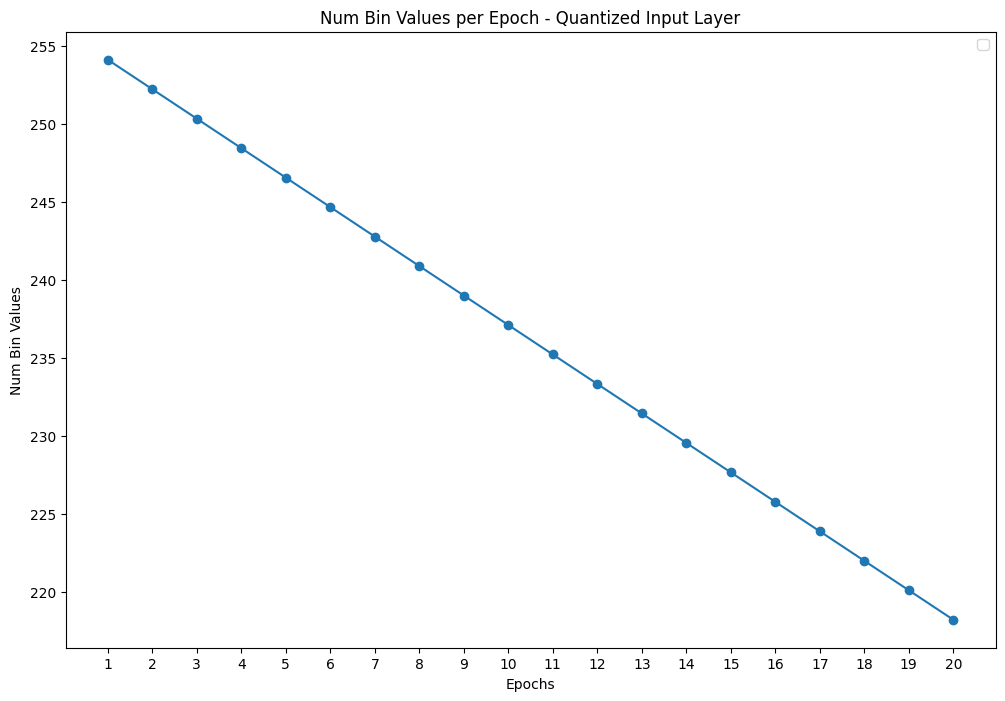

In [204]:
# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class LearnedQuantizedInput(tf.keras.layers.Layer):
    def __init__(self):
        super(LearnedQuantizedInput, self).__init__()

    def build(self, input_shape):
        self.num_bins = self.add_weight(shape=(), initializer=tf.constant_initializer(256), trainable=True, constraint=tf.keras.constraints.NonNeg())

    def call(self, inputs):
        num_bins = tf.sigmoid(self.num_bins) * 254 + 2  # Scale between 2 and 256
        max_abs_value = tf.reduce_max(tf.abs(inputs))
        scale = max_abs_value / (num_bins + eps_float32)

        quantized_inputs = tf.stop_gradient(tf.floor(inputs / scale)) + (inputs / scale - tf.stop_gradient(inputs / scale))
        dequantized_inputs = quantized_inputs * scale
        return dequantized_inputs
    
    def get_num_bins(self):
        return self.num_bins


class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)

    def call(self, inputs):
        output = tf.matmul(inputs, self.w) + self.b

        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_num_bins(self):
        return self.num_bins_w, self.num_bins_b


def custom_loss(y_true, y_pred, num_bins_of_layers):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    bin_penalty = 0.0
    penalty_rate = 1
    
    for num_bins in num_bins_of_layers:
        bin_penalty += tf.reduce_mean(num_bins)
    
    bin_penalty = bin_penalty / 256.0  # Scale to a range that makes sense relative to cross-entropy loss

    total_loss = cross_entropy_loss + penalty_rate * bin_penalty

    return total_loss



input_layer = Input(shape=(28, 28, 1))
quantized_input_layer = LearnedQuantizedInput()(input_layer)
flatten_layer = Flatten()(quantized_input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)

# Print layer details
for i, layer in enumerate(quantized_model.layers):
    print(f"\nLAYER {i}: {layer}")
    print(f"  - Input Shape: {layer.input_shape}")
    print(f"  - Output Shape: {layer.output_shape}")
    if hasattr(layer, 'get_scale'):
        print(f"  - Scale Shape: {layer.get_scale().shape}")


quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 
                                            [quantized_model.get_layer(index=1).get_num_bins()]),
    metrics=['accuracy']
)

scale_tracking_callback_input_layer = ScaleTrackingCallback(quantized_model.get_layer(index=1))

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[scale_tracking_callback_input_layer]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

scale_tracking_callback_input_layer.plot_num_bins_values(layer_name="Quantized Input Layer")

#scale_tracking_callback_input_layer.plot_scale_values(layer_name="Quantized Input Layer")
#scale_tracking_callback_dense_layer_1.plot_scale_values(layer_name="Quantized Dense Layer 1")
#scale_tracking_callback_dense_layer_2.plot_scale_values(layer_name="Quantized Dense Layer 2")
#scale_tracking_callback_dense_layer_2.plot_loss_accuracy()

